### Testing how to reproject data from an xarray

rioxarray https://corteva.github.io/rioxarray/stable/ (rasterio and .tif files)

pyresample https://pyresample.readthedocs.io/en/latest/ 

plotting with pyresample, some very cool representations https://pyresample.readthedocs.io/en/latest/howtos/plot.html

In [2]:
#
import xarray as xr
import rioxarray
import pyresample
import sys

sys.path.append("../")

from src.processing import windsat_datacube

In [3]:
# This only works with rasterio reading (tiff files)
from rasterio.enums import Resampling

# Open a .tif file with rasterio
ds = rioxarray.open_rasterio(r"..\data\raw\AMSRU_Mland_2017001A.tif", masked=True)
print("Original sizes")
print(ds.sizes)
print(ds.rio.crs)

# resampling
rds = ds.rio.reproject(
    ds.rio.crs,
    shape=(720, 1440),
    resampling=Resampling.bilinear,
)
print("Reprojected sizes")
print(rds.sizes)
print(rds.rio.crs)

Original sizes
Frozen({'band': 7, 'y': 586, 'x': 1383})
EPSG:6933
Reprojected sizes
Frozen({'band': 7, 'y': 720, 'x': 1440})
EPSG:6933


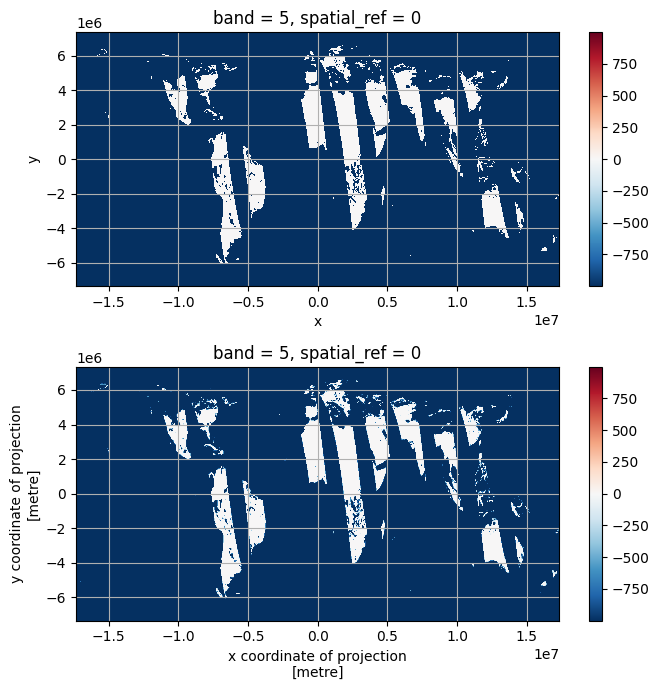

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ds.sel(band=5).plot(ax=ax[0], label="Original")
rds.sel(band=5).plot(ax=ax[1], label="Reprojected")
ax[0].grid()
ax[1].grid()

fig.tight_layout()

In [5]:
# Reprojecting Xarray datasets in .nc files
ds = xr.open_dataset(
    "../data/raw/Daily_Windsat/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc",
    decode_times=False,
)

# rename lat and lon grid to x and y:
ds = ds.rename({"longitude_grid": "x", "latitude_grid": "y"})

# Se the original CRS since the data array does not have it in metadata:
ds = ds.rio.write_crs("EPSG:4326")

# Set the x and y dimensions as coordinates
ds = ds.set_coords(names=["longitude", "latitude"])
ds = ds.rename({"longitude": "x", "latitude": "y"})
# Only avaialble with 2D or 3D arrays, we need to select each variable individually
ds_var = ds["tbtoa"].sel(
    polarization=0, swath_sector=1, frequency_band=0, look_direction=0
)

rds = ds_var.rio.reproject("EPSG:6933", resolution=25000)  # In meters!
rds

C:\Users\andre\AppData\Local\Temp\ipykernel_19364\526612598.py:15: UserWarning: rename 'longitude' to 'x' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"longitude": "x", "latitude": "y"})
C:\Users\andre\AppData\Local\Temp\ipykernel_19364\526612598.py:15: UserWarning: rename 'latitude' to 'y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename({"longitude": "x", "latitude": "y"})


<xarray.DataArray 'tbtoa' (y: 588, x: 1389)> Size: 3MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [253.89   , 253.9075 , 253.8875 , ..., 253.84   , 253.89249,
        253.9125 ],
       [251.10999, 251.0975 , 251.0725 , ..., 251.34749, 251.1975 ,
        251.15   ],
       ...,
       [225.33249, 225.1825 , 224.98999, ...,       nan, 225.70749,
        225.54   ],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * x            (x) float64 11kB -1.736e+07 -1.733e+07 ... 1.732e+07 1.734e+07
  * y            (y) float64 5kB 7.33e+06 7.305e+06 ... -7.32e+06 -7.345e+06
    spatial_ref  int32 4B 0
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

In [153]:
ds["tbtoa"]

<xarray.DataArray 'tbtoa' (polarization: 4, frequency_band: 5, y: 720, x: 1440,
                           look_direction: 2, swath_sector: 2)> Size: 332MB
[82944000 values with dtype=float32]
Coordinates:
    x            (x) float32 6kB ...
    y            (y) float32 3kB ...
    spatial_ref  int32 4B 0
Dimensions without coordinates: polarization, frequency_band, look_direction,
                                swath_sector
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

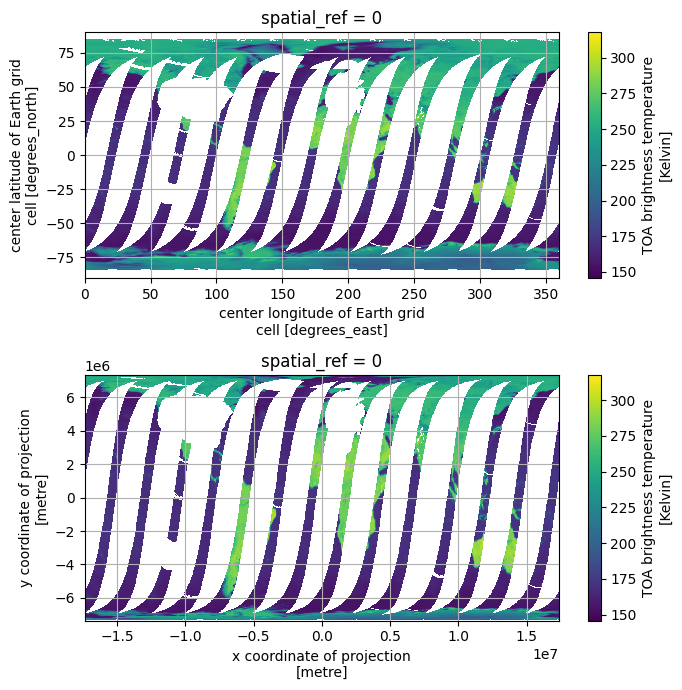

In [154]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ds["tbtoa"].sel(polarization=0, swath_sector=1, frequency_band=0, look_direction=0).roll({"x":4*180}).plot(ax=ax[0], label="Original")
rds.plot(ax=ax[1], label="Reprojected")
ax[0].grid()
ax[1].grid()

fig.tight_layout()

---


In [1]:
import xarray as xr
import rioxarray


# Load AMSR2 EASE v1 data 
v1_data = rioxarray.open_rasterio(r"..\data\raw\AMSRU_Mland_2017001A.tif", masked=True)
""" 
LPDR data file  AMSRU_Mland_{year}{day of year}{overpass (A or D)}.tif

The string “AMSRU_Mland” represents global land parameters derived from both AMSR-E and AMSR2 observations. 
The year string contains four digits. The day-of-year is the day in three digits since January 1 of the year. 
The overpass character is either ‘A’ for ascending (afternoon; P.M.) or ‘D’ for descending (morning; A.M.). 
The file extension “tif” is associated with the GeoTIFF file type. 

Additional bit-wise data quality files (QA)
AMSRU_Mland_{year}{day of year}{overpass (A or D)}_QA.tif 
"""
# v1_data.rio.write_crs("EPSG:4326", inplace=True)

' \nLPDR data file  AMSRU_Mland_{year}{day of year}{overpass (A or D)}.tif\n\nThe string “AMSRU_Mland” represents global land parameters derived from both AMSR-E and AMSR2 observations. \nThe year string contains four digits. The day-of-year is the day in three digits since January 1 of the year. \nThe overpass character is either ‘A’ for ascending (afternoon; P.M.) or ‘D’ for descending (morning; A.M.). \nThe file extension “tif” is associated with the GeoTIFF file type. \n\nAdditional bit-wise data quality files (QA)\nAMSRU_Mland_{year}{day of year}{overpass (A or D)}_QA.tif \n'

In [2]:

# Load AMSR2 EASE v2 data
v2_data = xr.open_dataset(r"..\data\raw\ka_36ghz\Ascending\GW1AM2_20170101_01D_EQMA_L3SGT36LA2220220_corrected.h5")
""" 
This dataset was converted using some code from Roberto, into the EASE v2 Grid
"""
# Add the spacial reference, acording to the shape of the array and the specifications
v2_data.rio.write_crs("EPSG:6933", inplace=True)

<xarray.Dataset>
Dimensions:                     (lon: 1388, lat: 584)
Coordinates:
  * lon                         (lon) float32 -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 -83.52 -81.98 ... 81.98 83.52
    spatial_ref                 int32 0
Data variables:
    Brightness Temperature (H)  (lat, lon) float32 ...
    Brightness Temperature (V)  (lat, lon) float32 ...
    Time Information            (lat, lon) float32 ...
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [13]:
v1_data.sizes, v2_data.sizes

(Frozen({'band': 7, 'y': 586, 'x': 1383}), Frozen({'lon': 1388, 'lat': 584}))

### Project v1 into v2

In [3]:
# rioxarray does not process the change in datum from EASEv1 to EASEv2. Manually select the original crs
v1_data.rio.write_crs("EPSG:3410", inplace=True)
v1_data.rio.crs

CRS.from_epsg(3410)

In [23]:
# Reproject the v1 data into lat-lon 
tb_v1_data = v1_data.sel(band=3)
v1_lonlat = tb_v1_data.where(tb_v1_data >0).rio.reproject(dst_crs="EPSG:3410")


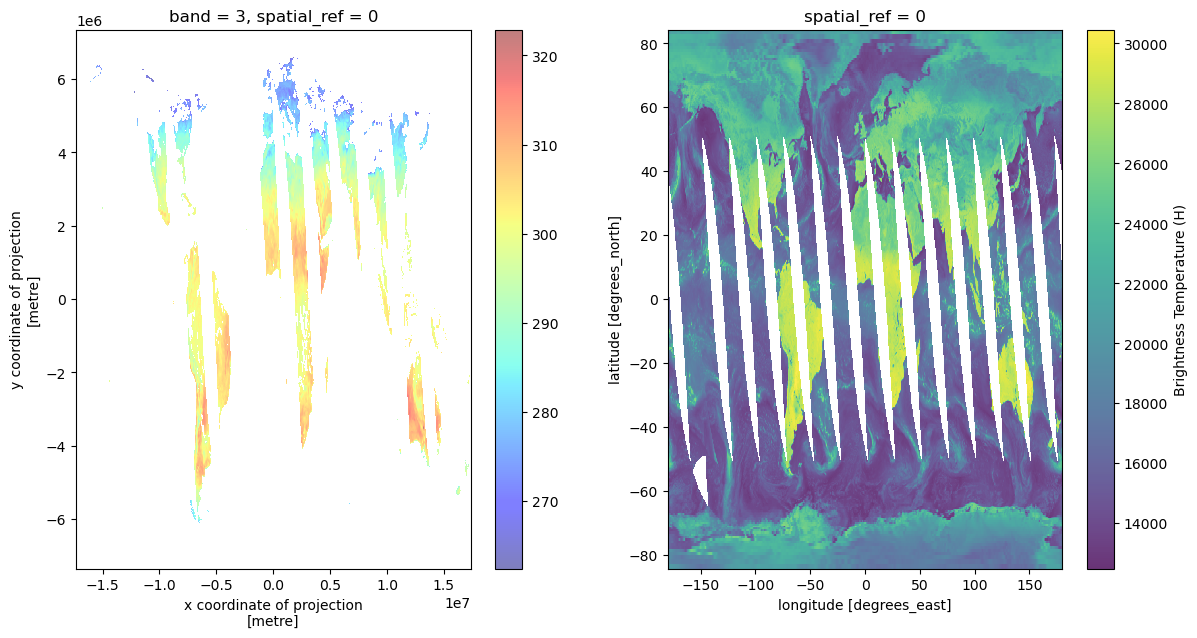

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(14,7))
v1_lonlat.plot(ax=ax[0], alpha = 0.5, cmap = "jet")
v2_data["Brightness Temperature (H)"].plot(ax=ax[1], alpha = 0.8)


In [1]:
# I dont care about the data, only the grid
""" 
Map the v2_data from lat-lon into xy
"""

from pyproj import Transformer
# transformer = Transformer.from_crs(crs_from="",crs_to="")




ModuleNotFoundError: No module named 'pyproj'

In [219]:
v2_data

<xarray.Dataset> Size: 10MB
Dimensions:                     (lon: 1388, lat: 584)
Coordinates:
  * lon                         (lon) float32 6kB -179.9 -179.6 ... 179.6 179.9
  * lat                         (lat) float32 2kB -83.52 -81.98 ... 81.98 83.52
    spatial_ref                 int32 4B 0
Data variables:
    Brightness Temperature (H)  (lat, lon) float32 3MB 2.049e+04 ... 1.988e+04
    Brightness Temperature (V)  (lat, lon) float32 3MB 2.344e+04 ... 2.18e+04
    Time Information            (lat, lon) float32 3MB -286.0 ... -1.026e+03
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

# .CONDA env
Use Gdal package, Translate method

In [2]:
from osgeo import gdal
dataset = gdal.Open(r"../data\raw\AMSRU_Mland_2017001A.tif", gdal.GA_ReadOnly)

In [3]:
print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 1383 x 586 x 7
Projection is PROJCS["NSIDC EASE-Grid Global",GEOGCS["NSIDC Authalic Sphere",DATUM["NSIDC_International_1924_Authalic_Sphere",SPHEROID["International 1924 Authalic Sphere",6371228,0,AUTHORITY["EPSG","7057"]],AUTHORITY["EPSG","1360"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","10346"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3410"]]
Origin = (-17334193.5375, 7344784.824994964)
Pixel Size = (25067.524999997386, -25067.524999997386)


In [6]:
# Fetching a raster band
label= 3
band = dataset.GetRasterBand(label)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=Float32
Min=-999.000, Max=322.903


In [21]:
#Reading raster data
scanline = band.ReadRaster(xoff=0, yoff=0,
                        xsize=band.XSize, ysize=1,
                        buf_xsize=band.XSize, buf_ysize=1,
                        buf_type=gdal.GDT_Float32)

In [22]:
import struct
# Unpack the binary string into a tuple of floats
tuple_of_floats = struct.unpack('f' * band.XSize, scanline)
len(tuple_of_floats)

1383

# Some solution I found here:
https://stackoverflow.com/questions/45972790/how-to-fix-the-reprojection-from-ease-2-grid-product-smap-to-geographic-coordina

In [6]:
import os
import h5py
import numpy as np
from osgeo import gdal, gdal_array, osr

In [29]:


data = v1_data.values
lat = v1_data.y
lon = v1_data.x

np_data = np.array(data)
np_lat = np.array(lat)
np_lon = np.array(lon)

num_cols = float(np_data.shape[1])
num_rows = float(np_data.shape[0])

xmin = np_lon.min()
xmax = np_lon.max()
ymin = np_lat.min()
ymax = np_lat.max()
xres = (xmax - xmin) / num_cols
yres = (ymax - ymin) / num_rows

_, nrows, ncols = np_data.shape
xres = (xmax - xmin) / float(ncols)
yres = (ymax - ymin) / float(nrows)
geotransform = (xmin, xres, 0, ymax, 0, -xres)

dataFileOutput = "./output.tif"
output_raster = gdal.GetDriverByName('GTiff').Create(dataFileOutput, ncols, nrows, 1, gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  
srs = osr.SpatialReference() 
srs.ImportFromEPSG(6933)  

output_raster.SetProjection(srs.ExportToWkt()) 
output_raster.GetRasterBand(1).WriteArray(np_data[2,:,:])  # Writes my array to the raster

del output_raster

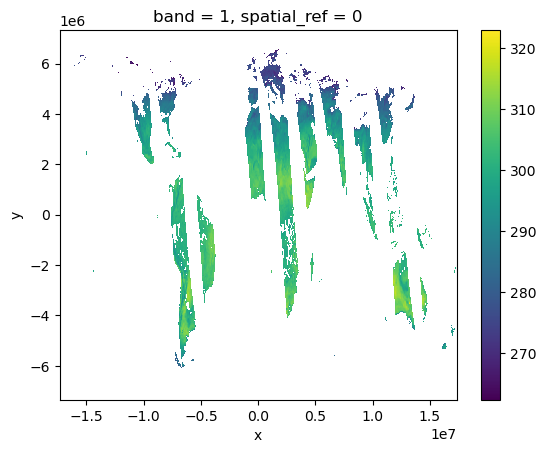

In [30]:
# Read output tiff

output_data = rioxarray.open_rasterio(r"output.tif", masked=True)
output_data.sel(band=1).where(output_data > 0).plot()
